In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

from scipy import stats

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

#opsin
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']
all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#Ephy
BS_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

stdfont = 14
stdyfrac = 0.06

# Animal Behavior

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33


C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching files for DS_16
Fetching files for DS_17
Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching f

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

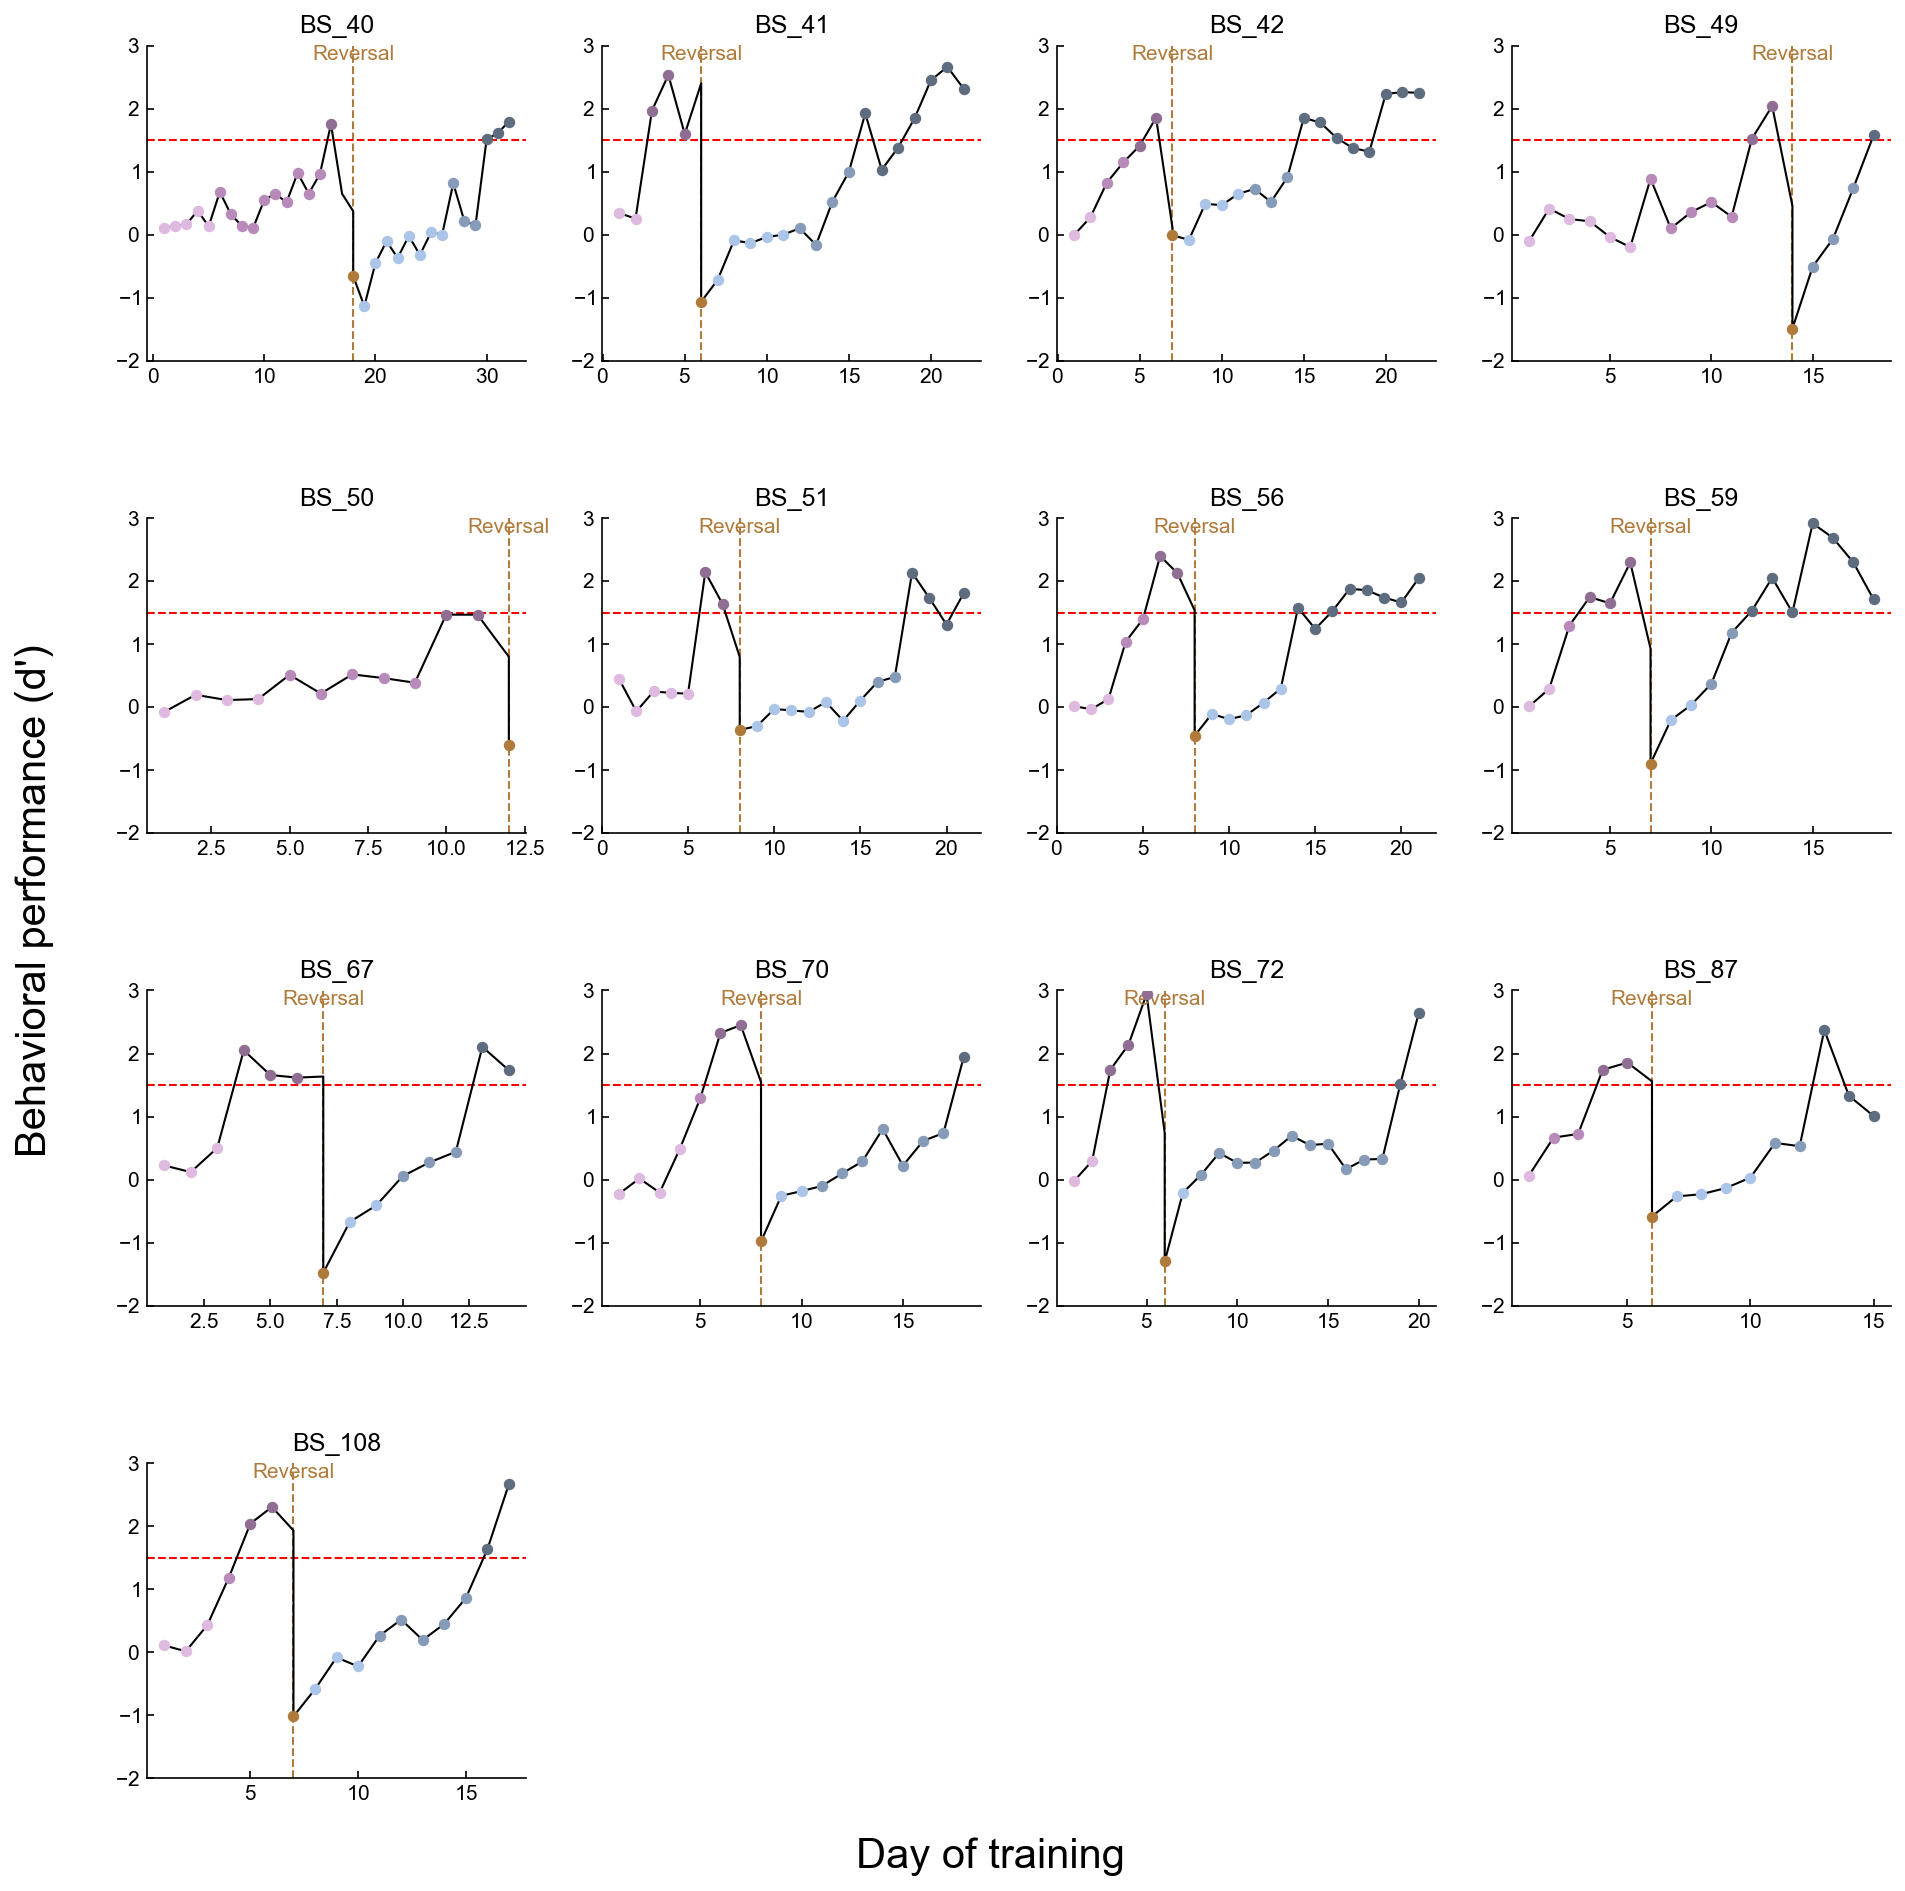

In [3]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(BS_animals,animalBehaviors,plot=True)

# Get data

In [4]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in BS_animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass
        


        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 731/731 [00:16<00:00, 45.57it/s]

AC       : 1288
M2       : 1628


## Assign each good cluster its learning phase

In [5]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1628/1628 [00:29<00:00, 55.47it/s] 

errors for: []


In [6]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1288/1288 [00:27<00:00, 46.54it/s] 

errors for: []


In [7]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

1628it [00:29, 55.32it/s] 


In [8]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

1288it [00:28, 45.45it/s] 


In [9]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

###MAY NEED TO MATCH AC AND M2 ANIMALS!!!

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_41' 'BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_87']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87']


In [10]:
print(len(FRmod_preearly_AC))
print(len(FRmod_prelate_AC))
print(len(FRmod_preexpert_AC))
print(len(FRmod_postearly_AC))
print(len(FRmod_postlate_AC))
print(len(FRmod_postexpert_AC))

148
188
75
349
299
103


In [11]:
print(len(FRmod_preearly_M2))
print(len(FRmod_prelate_M2))
print(len(FRmod_preexpert_M2))
print(len(FRmod_postearly_M2))
print(len(FRmod_postlate_M2))
print(len(FRmod_postexpert_M2))

159
240
199
349
204
218


In [12]:
#ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)

In [13]:
#ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['target']

In [14]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

In [15]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(ACphases))
print(len(AC_preearly))
print(len(AC_prelate))
print(len(AC_preexpert))
print(len(AC_postearly))
print(len(AC_postlate))
print(len(AC_postexpert))
print(len(AC_switch))
6+14+10+36+26+31+8

100%|██████████| 99/99 [00:01<00:00, 78.10it/s]

errors for: []
99
6
14
8
20
24
20
6


131

In [16]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(M2phases))
print(len(M2_preearly))
print(len(M2_prelate))
print(len(M2_preexpert))
print(len(M2_postearly))
print(len(M2_postlate))
print(len(M2_postexpert))
print(len(M2_switch))
7+13+10+19+24+19+9

100%|██████████| 103/103 [00:01<00:00, 90.30it/s]

errors for: []
103
7
13
10
19
24
19
9


101

# Analysis

# Pairwise correlation between a pair of neurons 

In [18]:
#Load from pickle
#all trials
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\AC_pairwise_corr.pickle', "rb") as f:
    AC_pairwise_corr_pickle = pickle.load(f) 
    
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\M2_pairwise_corr.pickle', "rb") as f:
    M2_pairwise_corr_pickle = pickle.load(f)  
    
#target trials
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\AC_pairwise_corr_target.pickle', "rb") as f:
    AC_pairwise_target_corr_pickle = pickle.load(f)  
    
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\M2_pairwise_corr_target.pickle', "rb") as f:
    M2_pairwise_target_corr_pickle = pickle.load(f)  

#nontarget trials
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\AC_pairwise_corr_nontarget.pickle', "rb") as f:
    AC_pairwise_nontarget_corr_pickle = pickle.load(f)  
    
with open('C:\\Users\insan\\Desktop\\PHRC_Dual\\Dual_Analysis_original\\M2_pairwise_corr_nontarget.pickle', "rb") as f:
    M2_pairwise_nontarget_corr_pickle = pickle.load(f)  

In [19]:
#Get pairwise data
#all trials
AC_preearly_corr = AC_pairwise_corr_pickle.prereversal_early
AC_prelate_corr = AC_pairwise_corr_pickle.prereversal_late
AC_preexpert_corr = AC_pairwise_corr_pickle.prereversal_expert
AC_postearly_corr = AC_pairwise_corr_pickle.postreversal_early
AC_postlate_corr = AC_pairwise_corr_pickle.postreversal_late
AC_postexpert_corr = AC_pairwise_corr_pickle.postreversal_expert

M2_preearly_corr = M2_pairwise_corr_pickle.prereversal_early
M2_prelate_corr = M2_pairwise_corr_pickle.prereversal_late
M2_preexpert_corr = M2_pairwise_corr_pickle.prereversal_expert
M2_postearly_corr = M2_pairwise_corr_pickle.postreversal_early
M2_postlate_corr = M2_pairwise_corr_pickle.postreversal_late
M2_postexpert_corr = M2_pairwise_corr_pickle.postreversal_expert

#target trials
AC_target_preearly_corr = AC_pairwise_target_corr_pickle.prereversal_early
AC_target_prelate_corr = AC_pairwise_target_corr_pickle.prereversal_late
AC_target_preexpert_corr = AC_pairwise_target_corr_pickle.prereversal_expert
AC_target_postearly_corr = AC_pairwise_target_corr_pickle.postreversal_early
AC_target_postlate_corr = AC_pairwise_target_corr_pickle.postreversal_late
AC_target_postexpert_corr = AC_pairwise_target_corr_pickle.postreversal_expert

M2_target_preearly_corr = M2_pairwise_target_corr_pickle.prereversal_early
M2_target_prelate_corr = M2_pairwise_target_corr_pickle.prereversal_late
M2_target_preexpert_corr = M2_pairwise_target_corr_pickle.prereversal_expert
M2_target_postearly_corr = M2_pairwise_target_corr_pickle.postreversal_early
M2_target_postlate_corr = M2_pairwise_target_corr_pickle.postreversal_late
M2_target_postexpert_corr = M2_pairwise_target_corr_pickle.postreversal_expert

#nontarget trials
AC_nontarget_preearly_corr = AC_pairwise_nontarget_corr_pickle.prereversal_early
AC_nontarget_prelate_corr = AC_pairwise_nontarget_corr_pickle.prereversal_late
AC_nontarget_preexpert_corr = AC_pairwise_nontarget_corr_pickle.prereversal_expert
AC_nontarget_postearly_corr = AC_pairwise_nontarget_corr_pickle.postreversal_early
AC_nontarget_postlate_corr = AC_pairwise_nontarget_corr_pickle.postreversal_late
AC_nontarget_postexpert_corr = AC_pairwise_nontarget_corr_pickle.postreversal_expert

M2_nontarget_preearly_corr = M2_pairwise_nontarget_corr_pickle.prereversal_early
M2_nontarget_prelate_corr = M2_pairwise_nontarget_corr_pickle.prereversal_late
M2_nontarget_preexpert_corr = M2_pairwise_nontarget_corr_pickle.prereversal_expert
M2_nontarget_postearly_corr = M2_pairwise_nontarget_corr_pickle.postreversal_early
M2_nontarget_postlate_corr = M2_pairwise_nontarget_corr_pickle.postreversal_late
M2_nontarget_postexpert_corr = M2_pairwise_nontarget_corr_pickle.postreversal_expert

In [20]:
type(AC_preearly_corr)

list

In [21]:
print('AC all trials')
print(len(AC_preearly_corr))
print(len(AC_prelate_corr))
print(len(AC_preexpert_corr))
print(len(AC_postearly_corr))
print(len(AC_postlate_corr))
print(len(AC_postexpert_corr))

print('AC target trials')
print(len(AC_target_preearly_corr))
print(len(AC_target_prelate_corr))
print(len(AC_target_preexpert_corr))
print(len(AC_target_postearly_corr))
print(len(AC_target_postlate_corr))
print(len(AC_target_postexpert_corr))

print('AC nontarget trials')
print(len(AC_nontarget_preearly_corr))
print(len(AC_nontarget_prelate_corr))
print(len(AC_nontarget_preexpert_corr))
print(len(AC_nontarget_postearly_corr))
print(len(AC_nontarget_postlate_corr))
print(len(AC_nontarget_postexpert_corr))



AC all trials
2376
2450
142
4194
2386
237
AC target trials
1478
1728
36
3665
2092
156
AC nontarget trials
1391
1606
36
3592
2038
156


In [22]:
print('M2 all trials')
print(len(M2_preearly_corr))
print(len(M2_prelate_corr))
print(len(M2_preexpert_corr))
print(len(M2_postearly_corr))
print(len(M2_postlate_corr))
print(len(M2_postexpert_corr))

print('M2 target trials')
print(len(M2_target_preearly_corr))
print(len(M2_target_prelate_corr))
print(len(M2_target_preexpert_corr))
print(len(M2_target_postearly_corr))
print(len(M2_target_postlate_corr))
print(len(M2_target_postexpert_corr))

print('M2 nontarget trials')
print(len(M2_nontarget_preearly_corr))
print(len(M2_nontarget_prelate_corr))
print(len(M2_nontarget_preexpert_corr))
print(len(M2_nontarget_postearly_corr))
print(len(M2_nontarget_postlate_corr))
print(len(M2_nontarget_postexpert_corr))

M2 all trials
1658
3228
1520
3683
1450
1761
M2 target trials
593
2799
253
3018
1265
1043
M2 nontarget trials
576
2704
253
2822
1133
1043


In [23]:
print(np.argwhere(np.isnan(AC_preearly_corr)))
print(np.argwhere(np.isnan(AC_prelate_corr)))
print(np.argwhere(np.isnan(AC_preexpert_corr)))
print(np.argwhere(np.isnan(AC_postearly_corr)))
print(np.argwhere(np.isnan(AC_postlate_corr)))
print(np.argwhere(np.isnan(AC_postexpert_corr)))

[]
[[1792]]
[]
[]
[]
[]


In [24]:
print(np.argwhere(np.isnan(AC_target_preearly_corr)))
print(np.argwhere(np.isnan(AC_target_prelate_corr)))
print(np.argwhere(np.isnan(AC_target_preexpert_corr)))
print(np.argwhere(np.isnan(AC_target_postearly_corr)))
print(np.argwhere(np.isnan(AC_target_postlate_corr)))
print(np.argwhere(np.isnan(AC_target_postexpert_corr)))

[]
[]
[]
[[2301]
 [2359]
 [2378]
 [2410]
 [2426]
 [2441]
 [2465]
 [2475]
 [2486]
 [2494]
 [2503]
 [2511]
 [2517]
 [2523]
 [2528]
 [2531]
 [2535]]
[]
[]


In [25]:
print(np.argwhere(np.isnan(AC_nontarget_preearly_corr)))
print(np.argwhere(np.isnan(AC_nontarget_prelate_corr)))
print(np.argwhere(np.isnan(AC_nontarget_preexpert_corr)))
print(np.argwhere(np.isnan(AC_nontarget_postearly_corr)))
print(np.argwhere(np.isnan(AC_nontarget_postlate_corr)))
print(np.argwhere(np.isnan(AC_nontarget_postexpert_corr)))

[]
[]
[]
[]
[]
[]


In [26]:
print(np.argwhere(np.isnan(M2_preearly_corr)))
print(np.argwhere(np.isnan(M2_prelate_corr)))
print(np.argwhere(np.isnan(M2_preexpert_corr)))
print(np.argwhere(np.isnan(M2_postearly_corr)))
print(np.argwhere(np.isnan(M2_postlate_corr)))
print(np.argwhere(np.isnan(M2_postexpert_corr)))

[[879]]
[]
[]
[[2114]
 [2120]]
[]
[]


In [27]:
print(np.argwhere(np.isnan(M2_target_preearly_corr)))
print(np.argwhere(np.isnan(M2_target_prelate_corr)))
print(np.argwhere(np.isnan(M2_target_preexpert_corr)))
print(np.argwhere(np.isnan(M2_target_postearly_corr)))
print(np.argwhere(np.isnan(M2_target_postlate_corr)))
print(np.argwhere(np.isnan(M2_target_postexpert_corr)))

[]
[]
[]
[[1430]
 [1434]
 [1768]
 [1786]]
[]
[]


In [28]:
print(np.argwhere(np.isnan(M2_nontarget_preearly_corr)))
print(np.argwhere(np.isnan(M2_nontarget_prelate_corr)))
print(np.argwhere(np.isnan(M2_nontarget_preexpert_corr)))
print(np.argwhere(np.isnan(M2_nontarget_postearly_corr)))
print(np.argwhere(np.isnan(M2_nontarget_postlate_corr)))
print(np.argwhere(np.isnan(M2_nontarget_postexpert_corr)))

[]
[]
[]
[[1508]
 [1659]]
[]
[]


# Calculate mean and std

In [29]:
#calculate mean
#all trials
AC_mean_preearly_corr = np.nanmean(AC_preearly_corr)
AC_mean_prelate_corr = np.nanmean(AC_prelate_corr)
AC_mean_preexpert_corr = np.nanmean(AC_preexpert_corr)
AC_mean_postearly_corr = np.nanmean(AC_postearly_corr)
AC_mean_postlate_corr = np.nanmean(AC_postlate_corr)
AC_mean_postexpert_corr = np.nanmean(AC_postexpert_corr)

M2_mean_preearly_corr = np.nanmean(M2_preearly_corr)
M2_mean_prelate_corr = np.nanmean(M2_prelate_corr)
M2_mean_preexpert_corr = np.nanmean(M2_preexpert_corr)
M2_mean_postearly_corr = np.nanmean(M2_postearly_corr)
M2_mean_postlate_corr = np.nanmean(M2_postlate_corr)
M2_mean_postexpert_corr = np.nanmean(M2_postexpert_corr)

#target
AC_mean_target_preearly_corr = np.nanmean(AC_target_preearly_corr)
AC_mean_target_prelate_corr = np.nanmean(AC_target_prelate_corr)
AC_mean_target_preexpert_corr = np.nanmean(AC_target_preexpert_corr)
AC_mean_target_postearly_corr = np.nanmean(AC_target_postearly_corr)
AC_mean_target_postlate_corr = np.nanmean(AC_target_postlate_corr)
AC_mean_target_postexpert_corr = np.nanmean(AC_target_postexpert_corr)

M2_mean_target_preearly_corr = np.nanmean(M2_target_preearly_corr)
M2_mean_target_prelate_corr = np.nanmean(M2_target_prelate_corr)
M2_mean_target_preexpert_corr = np.nanmean(M2_target_preexpert_corr)
M2_mean_target_postearly_corr = np.nanmean(M2_target_postearly_corr)
M2_mean_target_postlate_corr = np.nanmean(M2_target_postlate_corr)
M2_mean_target_postexpert_corr = np.nanmean(M2_target_postexpert_corr)

#nontarget
AC_mean_nontarget_preearly_corr = np.nanmean(AC_nontarget_preearly_corr)
AC_mean_nontarget_prelate_corr = np.nanmean(AC_nontarget_prelate_corr)
AC_mean_nontarget_preexpert_corr = np.nanmean(AC_nontarget_preexpert_corr)
AC_mean_nontarget_postearly_corr = np.nanmean(AC_nontarget_postearly_corr)
AC_mean_nontarget_postlate_corr = np.nanmean(AC_nontarget_postlate_corr)
AC_mean_nontarget_postexpert_corr = np.nanmean(AC_nontarget_postexpert_corr)

M2_mean_nontarget_preearly_corr = np.nanmean(M2_nontarget_preearly_corr)
M2_mean_nontarget_prelate_corr = np.nanmean(M2_nontarget_prelate_corr)
M2_mean_nontarget_preexpert_corr = np.nanmean(M2_nontarget_preexpert_corr)
M2_mean_nontarget_postearly_corr = np.nanmean(M2_nontarget_postearly_corr)
M2_mean_nontarget_postlate_corr = np.nanmean(M2_nontarget_postlate_corr)
M2_mean_nontarget_postexpert_corr = np.nanmean(M2_nontarget_postexpert_corr)

In [30]:
# #calculate std
# #all trials
# AC_std_preearly_corr = np.std(AC_preearly_corr)
# AC_std_prelate_corr = np.std(AC_prelate_corr)
# AC_std_preexpert_corr = np.std(AC_preexpert_corr)
# AC_std_postearly_corr = np.std(AC_postearly_corr)
# AC_std_postlate_corr = np.std(AC_postlate_corr)
# AC_std_postexpert_corr = np.std(AC_postexpert_corr)

# M2_std_preearly_corr = np.std(M2_preearly_corr)
# M2_std_prelate_corr = np.std(M2_prelate_corr)
# M2_std_preexpert_corr = np.std(M2_preexpert_corr)
# M2_std_postearly_corr = np.std(M2_postearly_corr)
# M2_std_postlate_corr = np.std(M2_postlate_corr)
# M2_std_postexpert_corr = np.std(M2_postexpert_corr)

# #target
# AC_std_target_preearly_corr = np.std(AC_target_preearly_corr)
# AC_std_target_prelate_corr = np.std(AC_target_prelate_corr)
# AC_std_target_preexpert_corr = np.std(AC_target_preexpert_corr)
# AC_std_target_postearly_corr = np.std(AC_target_postearly_corr)
# AC_std_target_postlate_corr = np.std(AC_target_postlate_corr)
# AC_std_target_postexpert_corr = np.std(AC_target_postexpert_corr)

# M2_std_target_preearly_corr = np.std(M2_target_preearly_corr)
# M2_std_target_prelate_corr = np.std(M2_target_prelate_corr)
# M2_std_target_preexpert_corr = np.std(M2_target_preexpert_corr)
# M2_std_target_postearly_corr = np.std(M2_target_postearly_corr)
# M2_std_target_postlate_corr = np.std(M2_target_postlate_corr)
# M2_std_target_postexpert_corr = np.std(M2_target_postexpert_corr)

# #nontarget
# AC_std_nontarget_preearly_corr = np.std(AC_nontarget_preearly_corr)
# AC_std_nontarget_prelate_corr = np.std(AC_nontarget_prelate_corr)
# AC_std_nontarget_preexpert_corr = np.std(AC_nontarget_preexpert_corr)
# AC_std_nontarget_postearly_corr = np.std(AC_nontarget_postearly_corr)
# AC_std_nontarget_postlate_corr = np.std(AC_nontarget_postlate_corr)
# AC_std_nontarget_postexpert_corr = np.std(AC_nontarget_postexpert_corr)

# M2_std_nontarget_preearly_corr = np.std(M2_nontarget_preearly_corr)
# M2_std_nontarget_prelate_corr = np.std(M2_nontarget_prelate_corr)
# M2_std_nontarget_preexpert_corr = np.std(M2_nontarget_preexpert_corr)
# M2_std_nontarget_postearly_corr = np.std(M2_nontarget_postearly_corr)
# M2_std_nontarget_postlate_corr = np.std(M2_nontarget_postlate_corr)
# M2_std_nontarget_postexpert_corr = np.std(M2_nontarget_postexpert_corr)

In [31]:
#AC
#mean
AC_parwise_mean = [AC_mean_preearly_corr,AC_mean_prelate_corr,AC_mean_preexpert_corr,
                  AC_mean_postearly_corr,AC_mean_postlate_corr,AC_mean_postexpert_corr]

AC_parwise_mean_target = [AC_mean_target_preearly_corr,AC_mean_target_prelate_corr,AC_mean_target_preexpert_corr,
                          AC_mean_target_postearly_corr,AC_mean_target_postlate_corr,AC_mean_target_postexpert_corr]

AC_parwise_mean_nontarget = [AC_mean_nontarget_preearly_corr,AC_mean_nontarget_prelate_corr,AC_mean_nontarget_preexpert_corr,
                             AC_mean_nontarget_postearly_corr,AC_mean_nontarget_postlate_corr,AC_mean_nontarget_postexpert_corr]


#M2
#mean
M2_parwise_mean = [M2_mean_preearly_corr,M2_mean_prelate_corr,M2_mean_preexpert_corr,
                  M2_mean_postearly_corr,M2_mean_postlate_corr,M2_mean_postexpert_corr]

M2_parwise_mean_target = [M2_mean_target_preearly_corr,M2_mean_target_prelate_corr,M2_mean_target_preexpert_corr,
                          M2_mean_target_postearly_corr,M2_mean_target_postlate_corr,M2_mean_target_postexpert_corr]

M2_parwise_mean_nontarget = [M2_mean_nontarget_preearly_corr,M2_mean_nontarget_prelate_corr,M2_mean_nontarget_preexpert_corr,
                             M2_mean_nontarget_postearly_corr,M2_mean_nontarget_postlate_corr,M2_mean_nontarget_postexpert_corr]


In [32]:
print(AC_parwise_mean)
print(AC_parwise_mean_target)
print(AC_parwise_mean_nontarget)

[0.04568545786527215, 0.03547153359689217, 0.061883133908931416, 0.041767393286042745, 0.03658882003846681, 0.09574726791599109]
[0.016135830369014753, 0.04254226454931218, -0.00031303134520993303, 0.04625037045399789, 0.04198793362515547, 0.13048316128311485]
[0.018255521046787994, 0.04713445691416483, 0.0564764428023781, 0.03773115742711204, 0.03380222962054258, 0.12098306445141378]


In [33]:
print(M2_parwise_mean)
print(M2_parwise_mean_target)
print(M2_parwise_mean_nontarget)

[0.06676137874356797, 0.10301180508307975, 0.04365090430194626, 0.05224635487441868, 0.080534805978022, 0.07666958888042238]
[0.05656922189138138, 0.10244118885052808, 0.007051147164796109, 0.048437472586359935, 0.06708376004474947, 0.07460155573792225]
[0.07274743352369731, 0.10326162021528235, 0.025021504224152134, 0.05545793631995297, 0.07388682761758963, 0.07185000110190669]


# Plot correlation along learning

In [34]:
stdfont = 14
stdyfrac = 0.06

In [35]:
def plot_corr_along_learning(pairwise_mean,ylim,yticks,path,title):
    def add_axis_size(fig, ax_w, ax_h, left, bottom):
        fig_w, fig_h = fig.get_size_inches()
        ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
        return ax

    def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
        fig_w = (ax_w + left + right) * 1.05
        fig_h = (ax_h + bottom + top) * 1.05
        fig = plt.figure(figsize=(fig_w, fig_h))
        ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
        return fig, ax

    fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

    ################################################################################################################

    #Plot figure

    PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

    for idx,column in enumerate(pairwise_mean):
        ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
    ax.plot([0,1,2],pairwise_mean[:3],color='k',linestyle=':',lw=1,alpha=1)
    ax.plot([3,4,5],pairwise_mean[3:],color='k',linestyle=':',lw=1,alpha=1)

    ################################################################################################################

    labels = ['Early','Late','Expert','Early','Late','Expert']

    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ylab = ax.set_ylabel(title)

    ax.set_xlim([-0.5,5.5])
    ax.set_xticks(range(6))
    ax.set_xticklabels(labels)
    ax.set_xlim(ax.get_xlim())

    xtick_pos_pre = ax.get_xticks()[1]
    xtick_pos_post = ax.get_xticks()[4]
    Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
    t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
    t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
    ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
    ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

    ax.tick_params(direction='in', length=6, width=1)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass

    ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

    ### Log
    # Y = 10**np.mean(np.log10(ax.get_ylim()))
    # t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
    # ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
    # ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

    ### Linear
    # Y = np.mean(ax.get_ylim())
    # t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
    # ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
    # ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

    artists = [ylab,t1,t2]
    fig.savefig(os.path.join(path),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


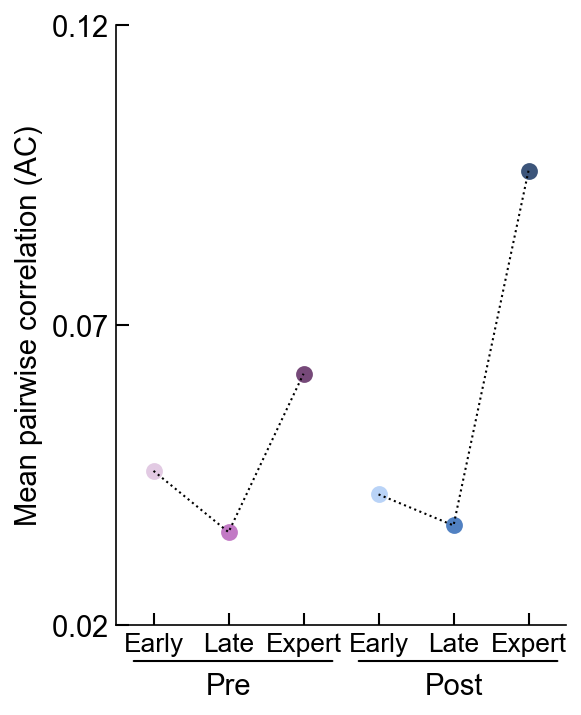

In [53]:
# ACylim = [-0.01,0.14]
# ACyticks = [-0.01,0,0.02,0.03,0.04,0.05,0.14]

ACylim = [0.02,0.12]
ACyticks = [0.02,0.07,0.12]

title = 'Mean pairwise correlation (AC)'
path = 'C:\\Users\insan\\Desktop\\PHRC_Dual\\Corr\\AC_pairwise_corr_learning.pdf'
plot_corr_along_learning(AC_parwise_mean,ACylim,ACyticks,path,title)

# title = 'Mean pairwise correlation (AC-target)'
# path = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\pairwise figs\\AC_target_pairwise_corr_learning.png'
# plot_corr_along_learning(AC_parwise_mean_target,ACylim,ACyticks,path,title)

# title = 'Mean pairwise correlation (AC-nontarget)'
# path = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\pairwise figs\\AC_nontarget_pairwise_corr_learning.png'
# plot_corr_along_learning(AC_parwise_mean_nontarget,ACylim,ACyticks,path,title)

meta NOT subset; don't know how to subset; dropped


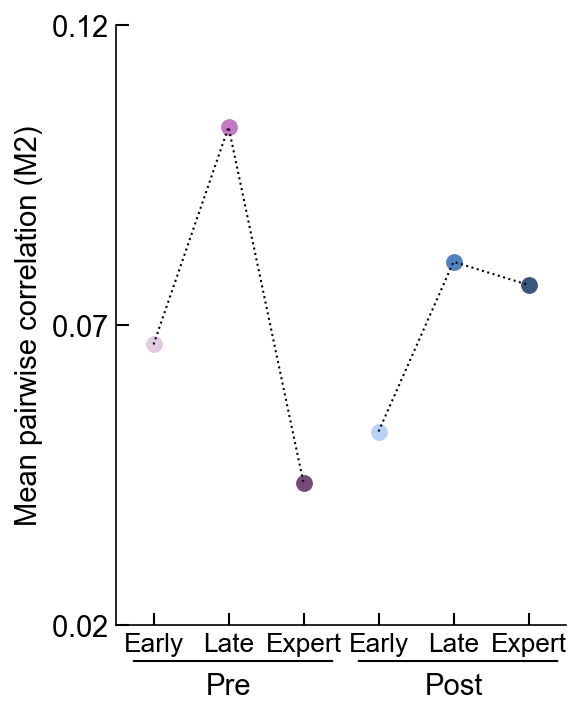

In [54]:
# M2ylim = [0,0.12]
# M2yticks = [0,0.02,0.04,0.06,0.08,0.1,0.12]

M2ylim = [0.02,0.12]
M2yticks = [0.02,0.07,0.12]

title = 'Mean pairwise correlation (M2)'
path = 'C:\\Users\insan\\Desktop\\PHRC_Dual\\Corr\\M2_pairwise_corr_learning.pdf'
plot_corr_along_learning(M2_parwise_mean,M2ylim,M2yticks,path,title)

# title = 'Mean pairwise correlation (M2-target)'
# path = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\pairwise figs\\M2_target_pairwise_corr_learning.png'
# plot_corr_along_learning(M2_parwise_mean_target,M2ylim,M2yticks,path,title)

# title = 'Mean pairwise correlation (M2-nontarget)'
# path = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\pairwise figs\\M2_nontarget_pairwise_corr_learning.png'
# plot_corr_along_learning(M2_parwise_mean_nontarget,M2ylim,M2yticks,path,title)

# Plot the histogram

# Normalize historgrams

In [139]:
def plot_histogram(data):
    preearly_corr = data[0]
    prelate_corr = data[1]
    preexpert_corr = data[2]
    postearly_corr = data[3]
    postlate_corr = data[4]
    postexpert_corr = data[5]
    
    #Histogram
    fig = plt.figure(figsize=(15,5))
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,2])
    ax4 = plt.subplot(gs[1,0])
    ax5 = plt.subplot(gs[1,1])
    ax6 = plt.subplot(gs[1,2])
    num_bins = 25

    ax1.hist(preearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax1.set_yticks([0,1000,2000])
    ax1.set_ylim([0,2500])
    ax1.set_xlabel('Pairwise correlation')
    ax1.set_ylabel('pairs')

    ax2.hist(prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax2.set_yticks([0,1000,2000])
    ax2.set_ylim([0,2500])
    ax2.set_xlabel('Pairwise correlation')
    ax2.set_ylabel('pairs')

    ax3.hist(preexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax3.set_yticks([0,1000,2000])
    ax3.set_ylim([0,2500])
    ax3.set_xlabel('Pairwise correlation')
    ax3.set_ylabel('pairs')

    ax4.hist(postearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax4.set_yticks([0,1000,2000])
    ax4.set_ylim([0,2500])
    ax4.set_xlabel('Pairwise correlation')
    ax4.set_ylabel('pairs')

    ax5.hist(postlate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax5.set_yticks([0,1000,2000])
    ax5.set_ylim([0,2500])
    ax5.set_xlabel('Pairwise correlation')
    ax5.set_ylabel('pairs')

    ax6.hist(postexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax6.set_yticks([0,1000,2000])
    ax6.set_ylim([0,2500])
    ax6.set_xlabel('Pairwise correlation')
    ax6.set_ylabel('pairs')
    
    #Normalization
    num_bins = 25

    hist_preearly, bins_preearly, _ = ax1.hist(preearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    hist_prelate, bins_prelate, _ = ax2.hist(prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    hist_preexpert, bins_preexpert, _ = ax3.hist(preexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')

    hist_postearly, bins_postearly, _ = ax4.hist(postearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    hist_postlate, bins_postlate, _ = ax5.hist(postlate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
    hist_postexpert, bins_postexpert, _ = ax6.hist(postexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')

    normalize_preearly = hist_preearly/sum(hist_preearly)
    normalize_prelate = hist_prelate/sum(hist_prelate)
    normalize_preexpert = hist_preexpert/sum(hist_preexpert)
    normalize_postearly = hist_postearly/sum(hist_postearly)
    normalize_postlate = hist_postlate/sum(hist_postlate)
    normalize_postexpert = hist_postexpert/sum(hist_postexpert)

    normalize_data = [normalize_preearly,normalize_prelate,normalize_preexpert,normalize_postearly,normalize_postlate,normalize_postexpert]

    fig = plt.figure(figsize=(15,5))
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,2])
    ax4 = plt.subplot(gs[1,0])
    ax5 = plt.subplot(gs[1,1])
    ax6 = plt.subplot(gs[1,2])

    ax1.bar(bins_preearly[:-1],normalize_preearly,width=np.diff(bins_preearly),edgecolor='k',label='AC')
    ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax1.set_yticks([0,0.1,0.2,0.3,0.4])
    ax1.set_ylim([0,0.4])
    ax1.set_xlabel('Pairwise correlation')
    ax1.set_ylabel('Probability')
    ax1.set_title('Pre-early')

    ax2.bar(bins_prelate[:-1],normalize_prelate,width=np.diff(bins_prelate),edgecolor='k')
    ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax2.set_yticks([0,0.1,0.2,0.3,0.4])
    ax2.set_ylim([0,0.4])
    ax2.set_xlabel('Pairwise correlation')
    ax2.set_ylabel('Probability')
    ax2.set_title('Pre-late')

    ax3.bar(bins_preexpert[:-1],normalize_preexpert,width=np.diff(bins_preexpert),edgecolor='k')
    ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax3.set_yticks([0,0.1,0.2,0.3,0.4])
    ax3.set_ylim([0,0.4])
    ax3.set_xlabel('Pairwise correlation')
    ax3.set_ylabel('Probability')
    ax3.set_title('Pre-expert')

    ax4.bar(bins_postearly[:-1],normalize_postearly,width=np.diff(bins_postearly),edgecolor='k')
    ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax4.set_yticks([0,0.1,0.2,0.3,0.4])
    ax4.set_ylim([0,0.4])
    ax4.set_xlabel('Pairwise correlation')
    ax4.set_ylabel('Probability')
    ax4.set_title('Post-early')

    ax5.bar(bins_postlate[:-1],normalize_postlate,width=np.diff(bins_postlate),edgecolor='k')
    ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax5.set_yticks([0,0.1,0.2,0.3,0.4])
    ax5.set_ylim([0,0.4])
    ax5.set_xlabel('Pairwise correlation')
    ax5.set_ylabel('Probability')
    ax5.set_title('Post-late')

    ax6.bar(bins_postexpert[:-1],normalize_postexpert,width=np.diff(bins_postexpert),edgecolor='k')
    ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
    ax6.set_yticks([0,0.1,0.2,0.3,0.4])
    ax6.set_ylim([0,0.4])
    ax6.set_xlabel('Pairwise correlation')
    ax6.set_ylabel('Probability')
    ax6.set_title('Post-expert')

    ax1.legend()

    #plt.suptitle('AC pairwise correlation')

    plt.tight_layout()

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


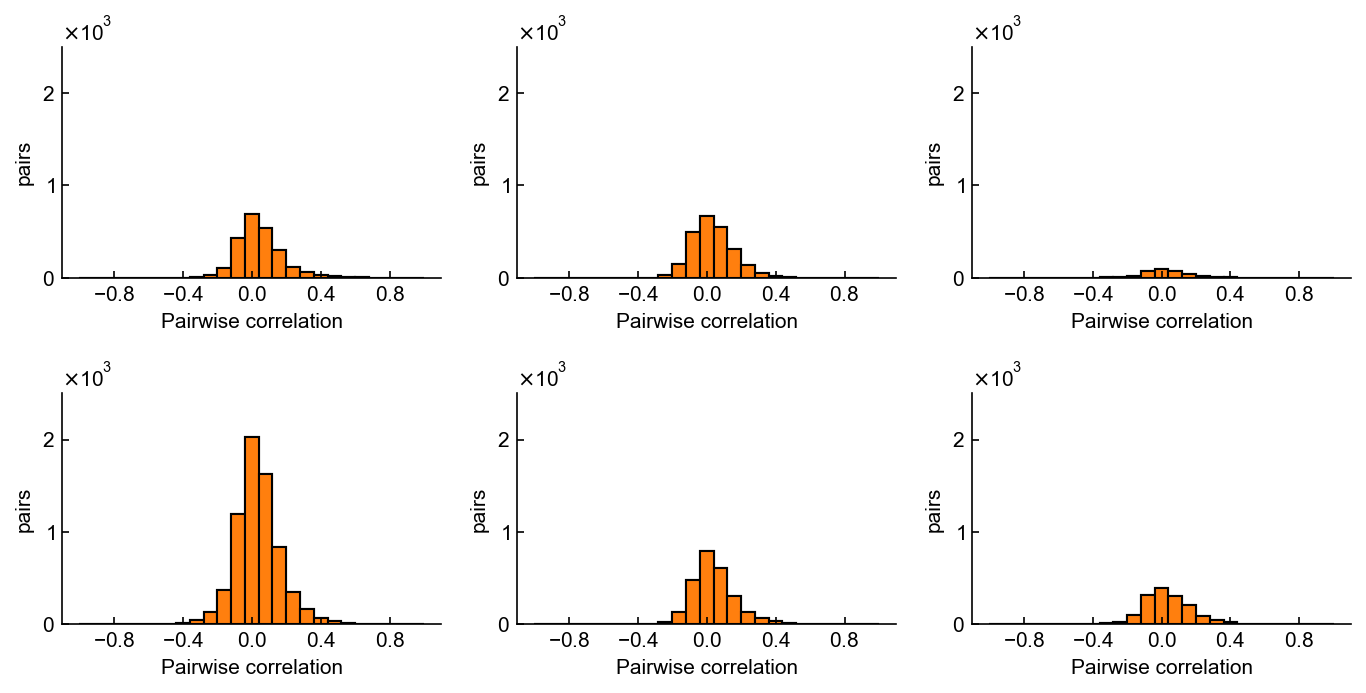

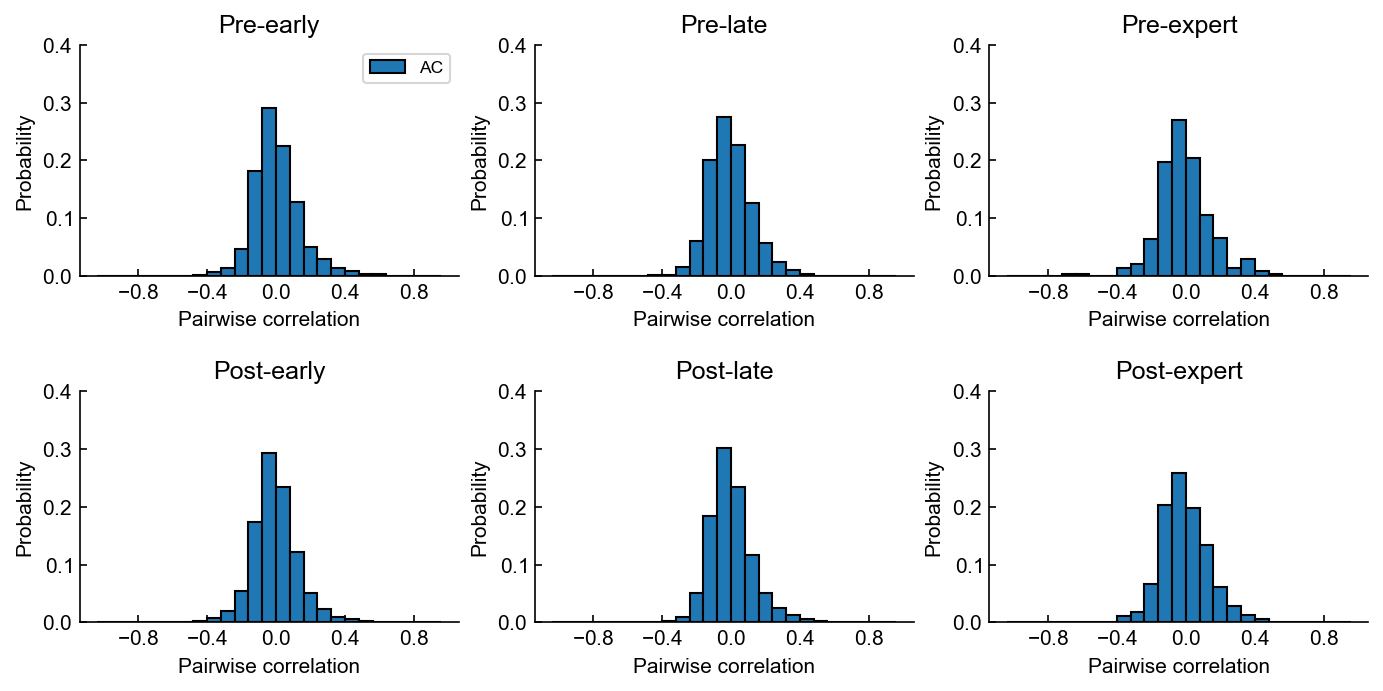

In [140]:
AC_corr = [AC_preearly_corr,AC_prelate_corr,AC_preexpert_corr,AC_postearly_corr,AC_postlate_corr,AC_postexpert_corr]
plot_histogram(AC_corr)

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


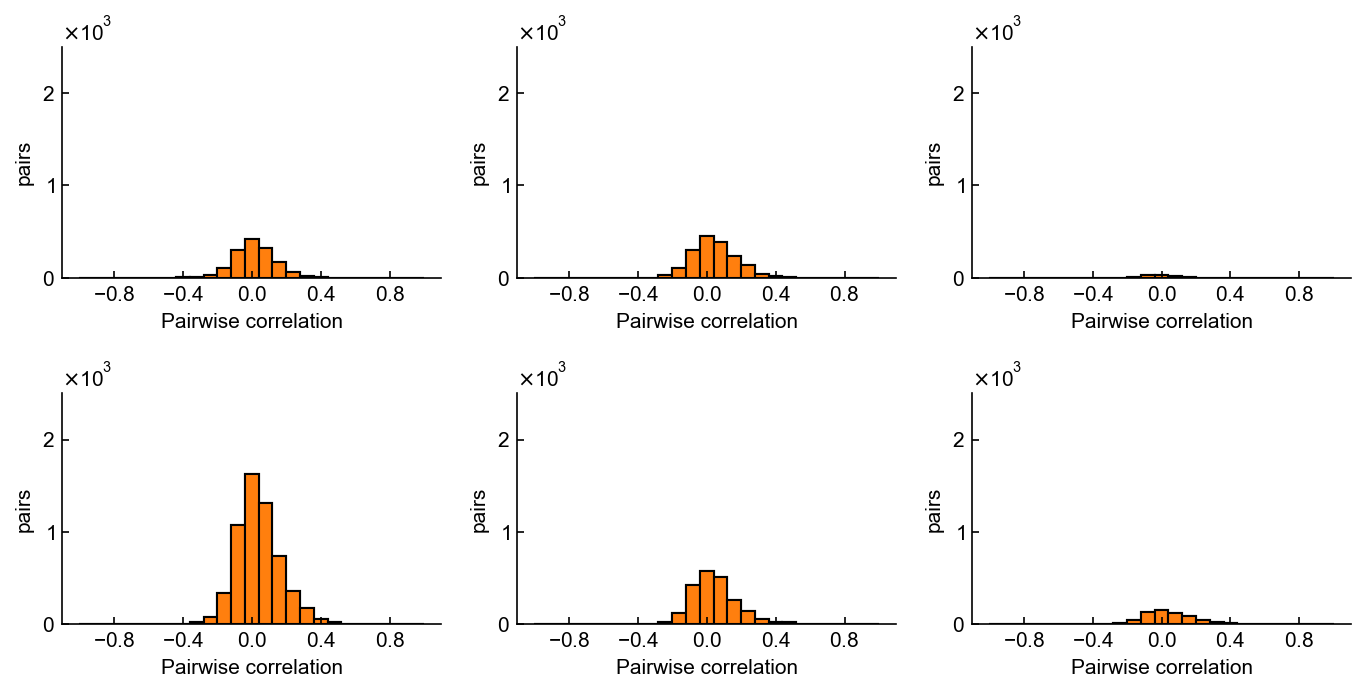

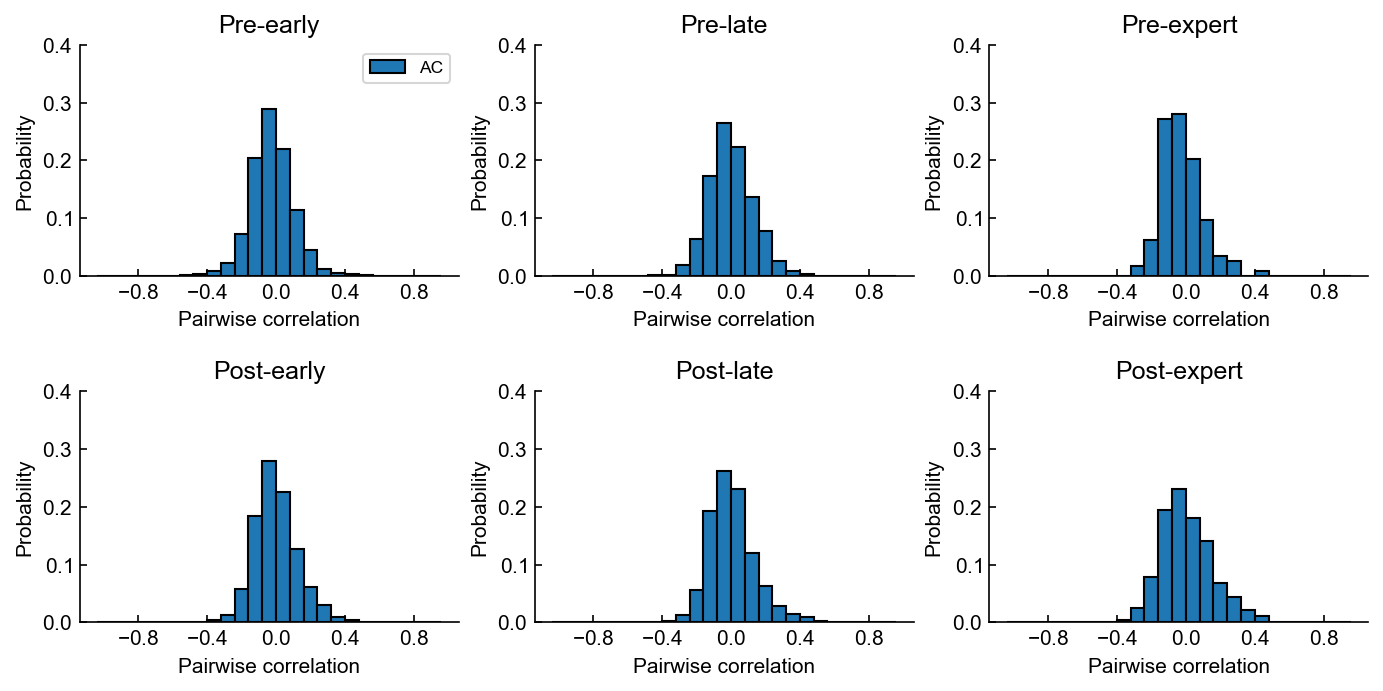

In [141]:
AC_target_corr = [AC_target_preearly_corr,AC_target_prelate_corr,AC_target_preexpert_corr,AC_target_postearly_corr,AC_target_postlate_corr,AC_target_postexpert_corr]
plot_histogram(AC_target_corr)

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


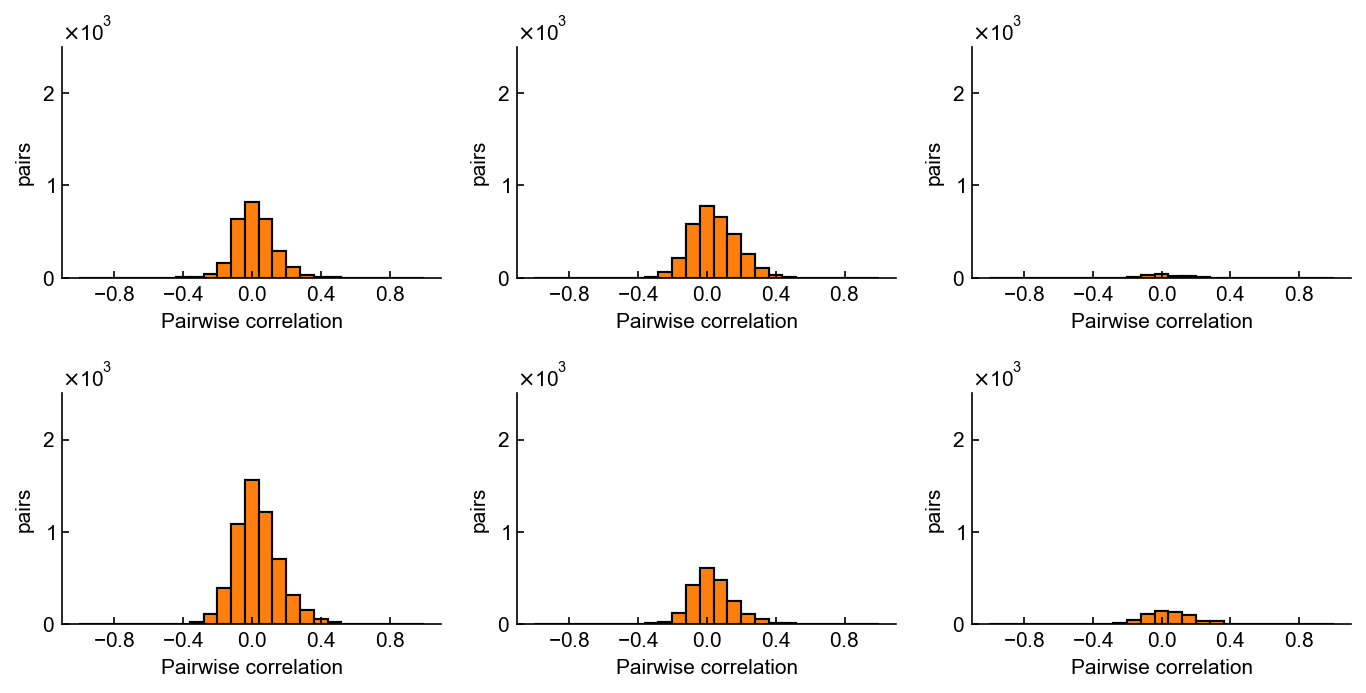

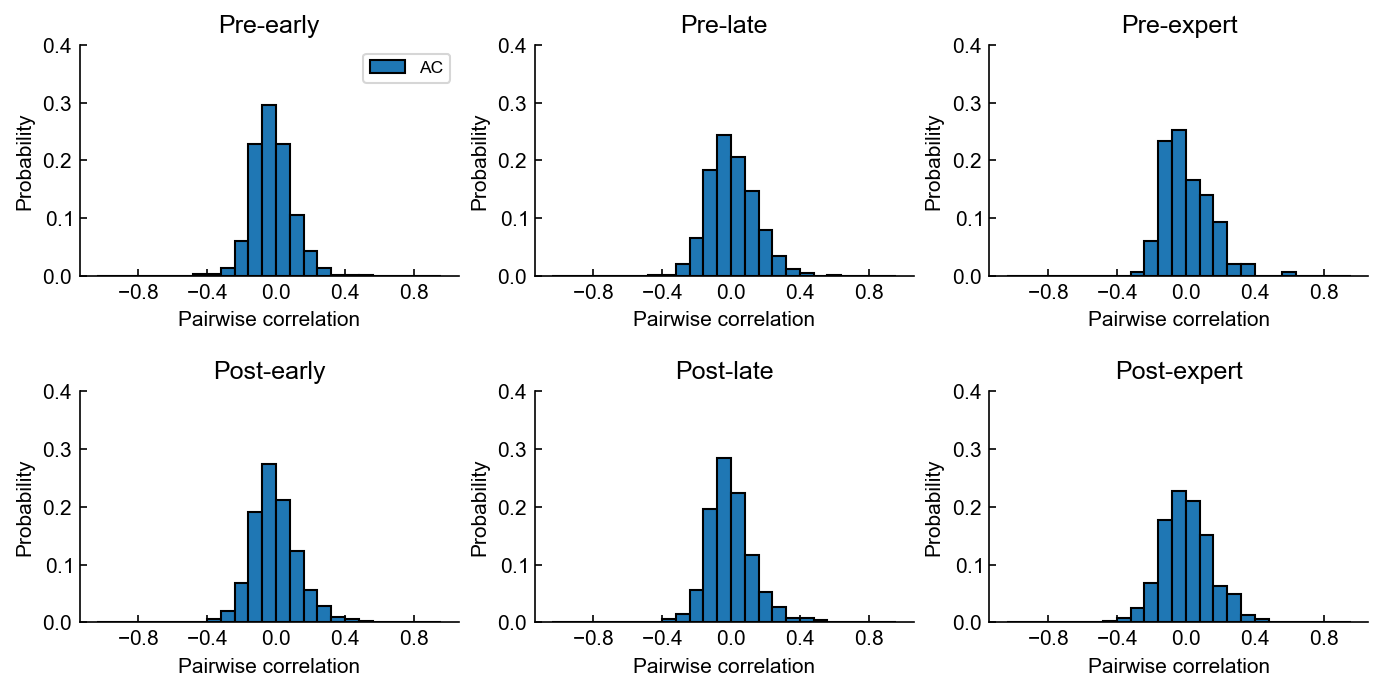

In [142]:
AC_nontarget_corr = [AC_nontarget_preearly_corr,AC_nontarget_prelate_corr,AC_nontarget_preexpert_corr,AC_nontarget_postearly_corr,AC_nontarget_postlate_corr,AC_nontarget_postexpert_corr]
plot_histogram(AC_nontarget_corr)

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


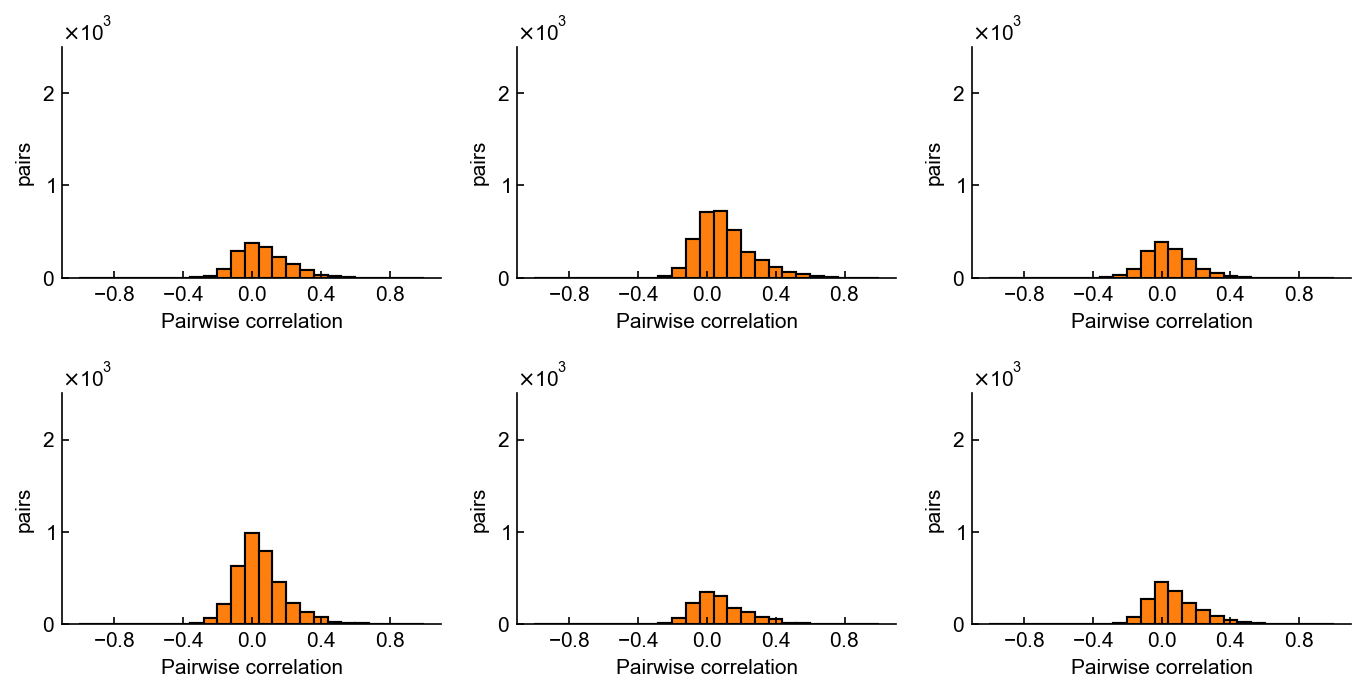

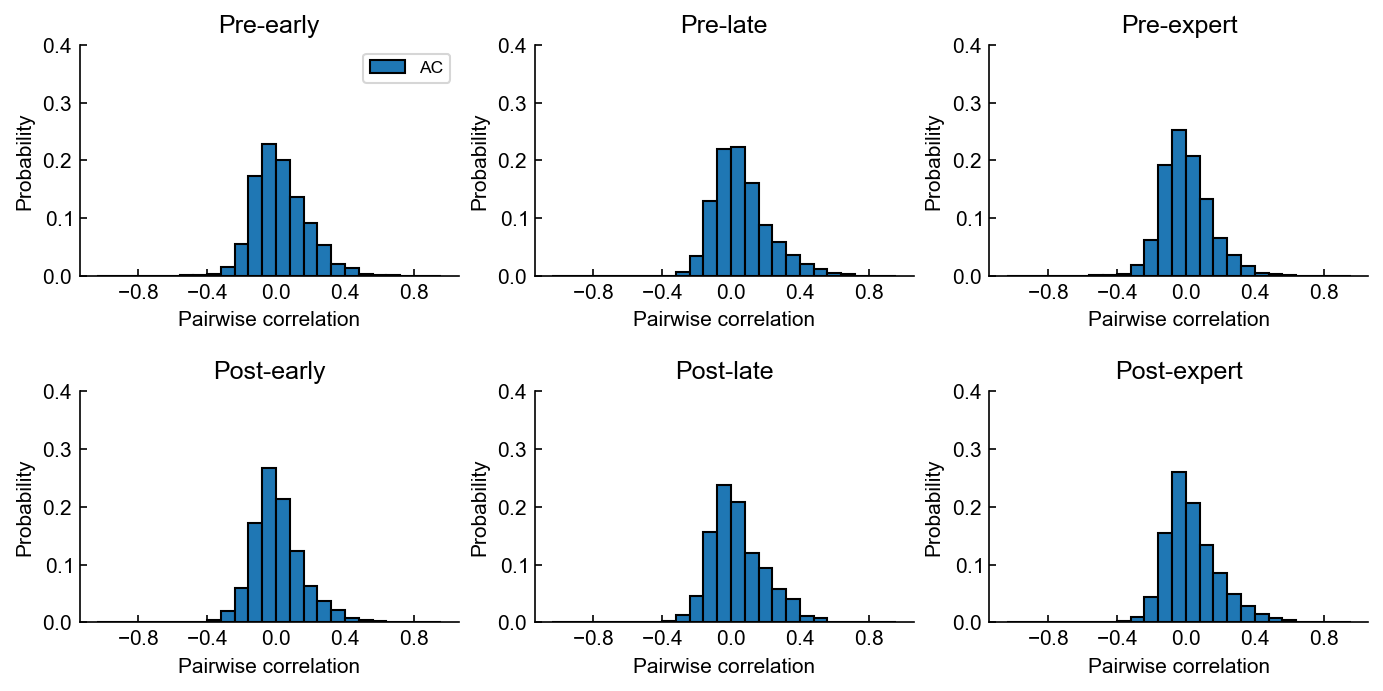

In [143]:
M2_corr = [M2_preearly_corr,M2_prelate_corr,M2_preexpert_corr,M2_postearly_corr,M2_postlate_corr,M2_postexpert_corr]
plot_histogram(M2_corr)

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


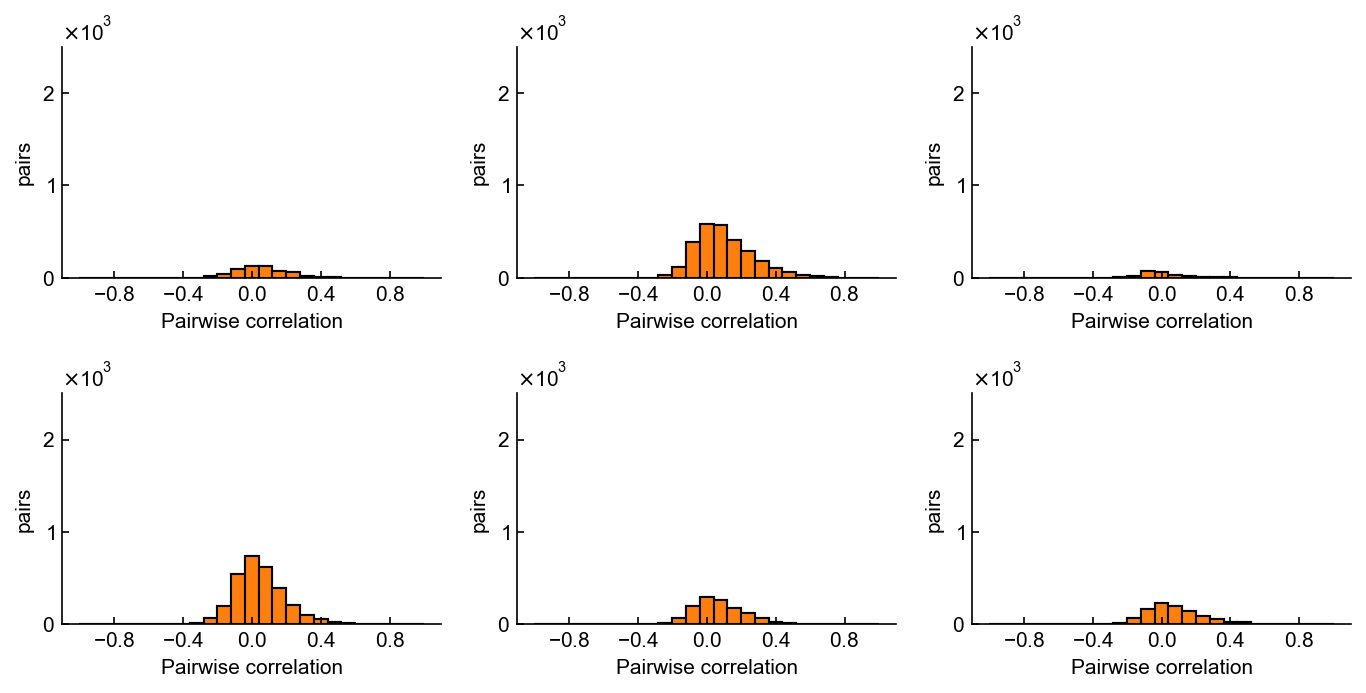

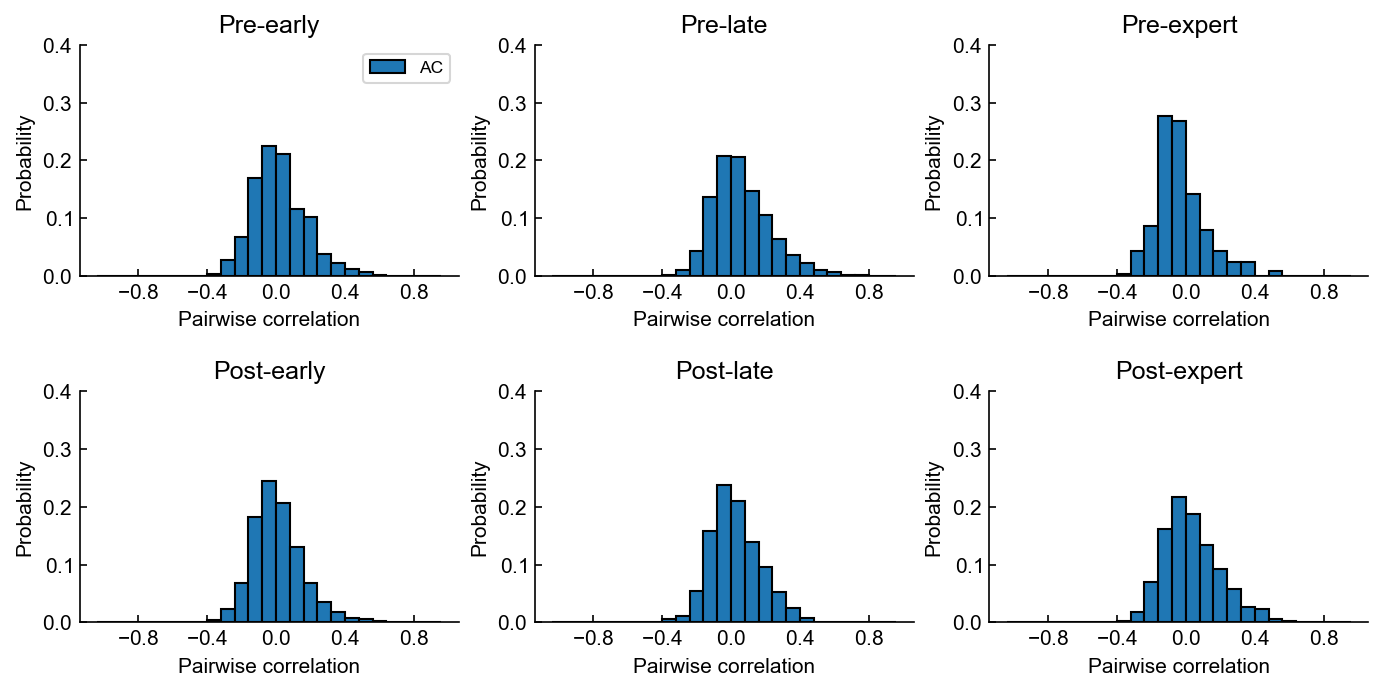

In [144]:
M2_target_corr = [M2_target_preearly_corr,M2_target_prelate_corr,M2_target_preexpert_corr,M2_target_postearly_corr,M2_target_postlate_corr,M2_target_postexpert_corr]
plot_histogram(M2_target_corr)

C:\Users\insan\AppData\Local\Temp\ipykernel_27448\4155677263.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


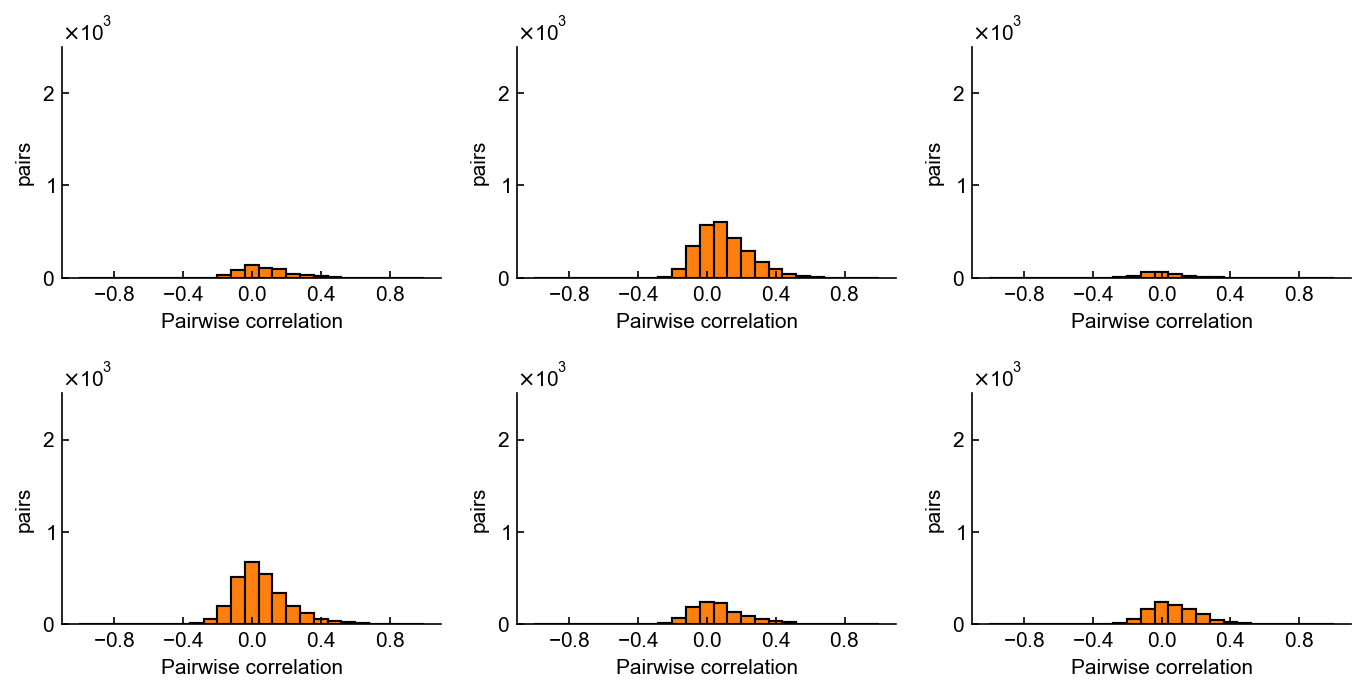

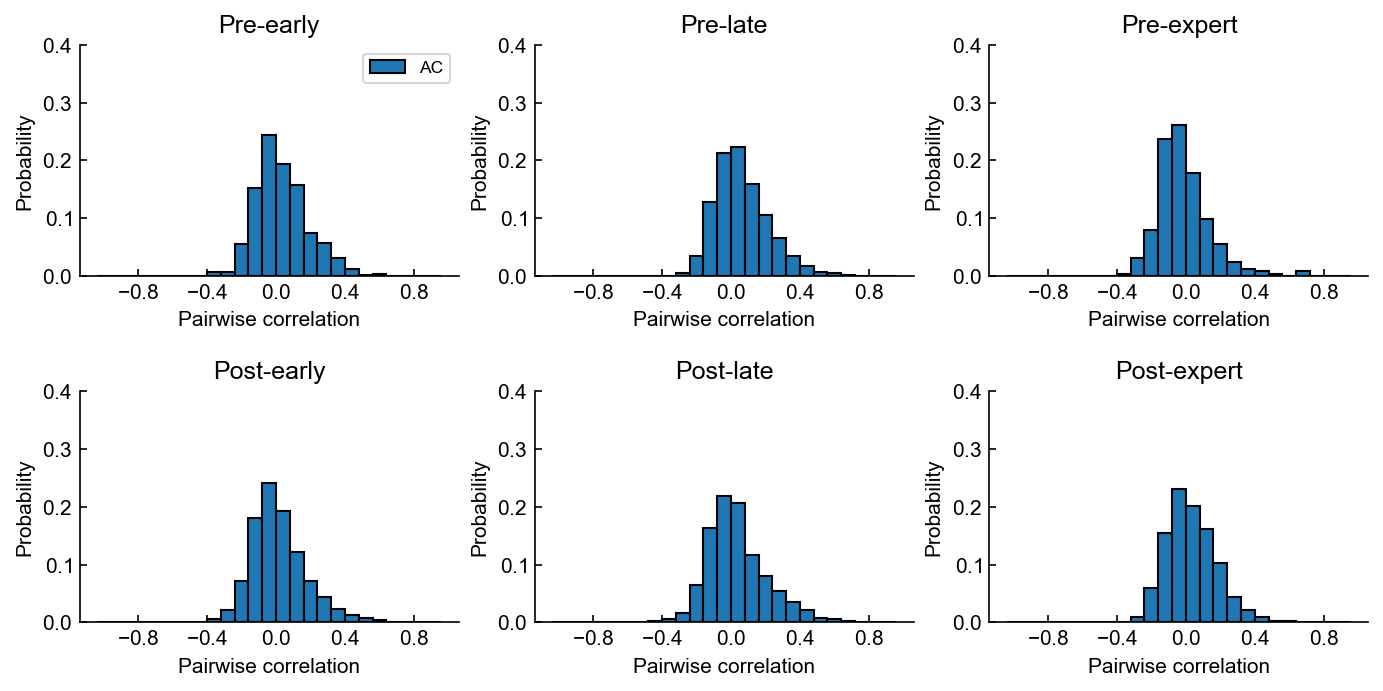

In [145]:
M2_nontarget_corr = [M2_nontarget_preearly_corr,M2_nontarget_prelate_corr,M2_nontarget_preexpert_corr,M2_nontarget_postearly_corr,M2_nontarget_postlate_corr,M2_nontarget_postexpert_corr]
plot_histogram(M2_nontarget_corr)

# Significance test

In [57]:
#Mann–Whitney U test

In [44]:
AC_Data = SimpleNamespace()
AC_Data.preearly = AC_preearly_corr
AC_Data.prelate = AC_prelate_corr
AC_Data.preexpert = AC_preexpert_corr
AC_Data.postearly = AC_postearly_corr
AC_Data.postlate = AC_postlate_corr
AC_Data.postexpert = AC_postexpert_corr

AC_targetData = SimpleNamespace()
AC_targetData.preearly = AC_target_preearly_corr
AC_targetData.prelate = AC_target_prelate_corr
AC_targetData.preexpert = AC_target_preexpert_corr
AC_targetData.postearly = AC_target_postearly_corr
AC_targetData.postlate = AC_target_postlate_corr
AC_targetData.postexpert = AC_target_postexpert_corr

AC_nontargetData = SimpleNamespace()
AC_nontargetData.preearly = AC_nontarget_preearly_corr
AC_nontargetData.prelate = AC_nontarget_prelate_corr
AC_nontargetData.preexpert = AC_nontarget_preexpert_corr
AC_nontargetData.postearly = AC_nontarget_postearly_corr
AC_nontargetData.postlate = AC_nontarget_postlate_corr
AC_nontargetData.postexpert = AC_nontarget_postexpert_corr

In [45]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_Data)

            Source          SS       DF        MS          F         p-unc  \
0            phase    0.083413      3.0  0.027804   1.515666  2.081749e-01   
1          context    0.011337      1.0  0.011337   0.617996  4.318030e-01   
2  phase * context    0.844055      3.0  0.281352  15.337044  5.798431e-10   
3         Residual  336.549603  18346.0  0.018345        NaN           NaN   

        np2  
0  0.000248  
1  0.000034  
2  0.002502  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  2.080574e-11  8.322296e-11 -0.383603
8     post-late  baseline  experimental  1.417485e-01  1.889980e-01  0.038721
9    pre-expert  baseline  experimental  2.027947e-01  2.027947e-01 -0.115436
10     pre-late  baseline  experimental  4.476959e-02  8.953918e-02  0.078446
key preearly has 2376 non-nan elements
key prelate has 2449 non-nan elements
key preexpert has 142 non-nan elements
key postearly has 4194 non-nan e

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,14899095.0,two-sided,4.963578e-02,1.489073e-01,fdr_bh,0.034832
1,phase,-,post-expert,pre-expert,False,False,5611407.0,two-sided,6.834563e-01,6.834563e-01,fdr_bh,-0.013800
2,phase,-,post-expert,pre-late,False,False,10970376.0,two-sided,2.889858e-02,1.489073e-01,fdr_bh,0.030624
3,phase,-,post-late,pre-expert,False,False,8151862.0,two-sided,2.376550e-01,3.564825e-01,fdr_bh,-0.049480
4,phase,-,post-late,pre-late,False,False,15946518.0,two-sided,6.774016e-01,6.834563e-01,fdr_bh,-0.004624
5,phase,-,pre-expert,pre-late,False,False,6198740.0,two-sided,1.502120e-01,3.004240e-01,fdr_bh,0.045571
6,context,-,baseline,experimental,False,False,34642300.0,two-sided,2.327226e-01,NaN,NaN,0.027596
7,phase * context,post-expert,baseline,experimental,False,False,368611.0,two-sided,2.080574e-11,8.322296e-11,fdr_bh,-0.383603
8,phase * context,post-late,baseline,experimental,False,False,5112290.0,two-sided,1.417485e-01,1.889980e-01,fdr_bh,0.038721
9,phase * context,pre-expert,baseline,experimental,False,False,157977.0,two-sided,2.027947e-01,2.027947e-01,fdr_bh,-0.115436


In [46]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_targetData)

            Source          SS       DF        MS          F         p-unc  \
0            phase    1.824839      3.0  0.608280  37.103014  7.092663e-24   
1          context    0.324692      1.0  0.324692  19.805114  8.640318e-06   
2  phase * context    1.325914      3.0  0.441971  26.958764  2.225783e-17   
3         Residual  233.717844  14256.0  0.016394        NaN           NaN   

        np2  
0  0.007747  
1  0.001387  
2  0.005641  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.510446e-14  6.041782e-14 -0.654729
8     post-late  baseline  experimental  6.451751e-02  8.602335e-02  0.032896
9    pre-expert  baseline  experimental  2.446389e-01  2.446389e-01  0.133472
10     pre-late  baseline  experimental  5.440587e-08  1.088117e-07 -0.208105
key preearly has 1478 non-nan elements
key prelate has 1728 non-nan elements
key preexpert has 36 non-nan elements
key postearly has 3648 non-nan el

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,11195975.0,two-sided,3.458262e-02,3.458262e-02,fdr_bh,0.038634
1,phase,-,post-expert,pre-expert,False,False,3289776.0,two-sided,4.751375e-16,2.850825e-15,fdr_bh,0.265552
2,phase,-,post-expert,pre-late,False,False,6582244.0,two-sided,9.527604e-09,1.905521e-08,fdr_bh,0.150221
3,phase,-,post-late,pre-expert,False,False,4855376.0,two-sided,1.941048e-12,5.823145e-12,fdr_bh,0.225722
4,phase,-,post-late,pre-late,False,False,9700809.0,two-sided,1.998354e-05,2.997531e-05,fdr_bh,0.111206
5,phase,-,pre-expert,pre-late,False,False,2275307.0,two-sided,5.204972e-04,6.245966e-04,fdr_bh,-0.115916
6,context,-,baseline,experimental,False,False,20007650.0,two-sided,1.163986e-02,NaN,NaN,-0.059907
7,phase * context,post-expert,baseline,experimental,False,False,181288.0,two-sided,1.510446e-14,6.041782e-14,fdr_bh,-0.654729
8,phase * context,post-late,baseline,experimental,False,False,3927508.0,two-sided,6.451751e-02,8.602335e-02,fdr_bh,0.032896
9,phase * context,pre-expert,baseline,experimental,False,False,29620.0,two-sided,2.446389e-01,2.446389e-01,fdr_bh,0.133472


In [51]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(AC_nontargetData)

            Source          SS       DF        MS          F         p-unc  \
0            phase    0.486602      3.0  0.162201   9.634812  2.365266e-06   
1          context    0.977040      1.0  0.977040  58.036708  2.671346e-14   
2  phase * context    0.490859      3.0  0.163620   9.719096  2.093214e-06   
3         Residual  389.070331  23111.0  0.016835        NaN           NaN   

        np2  
0  0.001249  
1  0.002505  
2  0.001260  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.923466e-02  3.846933e-02 -0.084955
8     post-late  baseline  experimental  3.472564e-01  3.472564e-01 -0.033517
9    pre-expert  baseline  experimental  9.935429e-02  1.324724e-01 -0.246404
10     pre-late  baseline  experimental  3.830558e-16  1.532223e-15 -0.227954


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,24948233.0,two-sided,8.353178e-01,9.998769e-01,fdr_bh,-0.000375
1,phase,-,post-expert,pre-expert,False,False,9857698.0,two-sided,3.563107e-06,7.126213e-06,fdr_bh,0.115660
2,phase,-,post-expert,pre-late,False,False,19015996.0,two-sided,9.998769e-01,9.998769e-01,fdr_bh,0.006981
3,phase,-,post-late,pre-expert,False,False,12174504.0,two-sided,3.235799e-06,7.126213e-06,fdr_bh,0.116290
4,phase,-,post-late,pre-late,False,False,23472944.0,two-sided,8.383879e-01,9.998769e-01,fdr_bh,0.007387
5,phase,-,pre-expert,pre-late,False,False,8252228.0,two-sided,2.886051e-06,7.126213e-06,fdr_bh,-0.112944
6,context,-,baseline,experimental,False,False,49006178.0,two-sided,2.438960e-13,NaN,NaN,-0.117012
7,phase * context,post-expert,baseline,experimental,False,False,1754651.0,two-sided,1.923466e-02,3.846933e-02,fdr_bh,-0.084955
8,phase * context,post-late,baseline,experimental,False,False,6051765.0,two-sided,3.472564e-01,3.472564e-01,fdr_bh,-0.033517
9,phase * context,pre-expert,baseline,experimental,False,False,192006.0,two-sided,9.935429e-02,1.324724e-01,fdr_bh,-0.246404


In [53]:
M2_Data = SimpleNamespace()
M2_Data.preearly = M2_preearly_corr
M2_Data.prelate = M2_prelate_corr
M2_Data.preexpert = M2_preexpert_corr
M2_Data.postearly = M2_postearly_corr
M2_Data.postlate = M2_postlate_corr
M2_Data.postexpert = M2_postexpert_corr

M2_targetData = SimpleNamespace()
M2_targetData.preearly = M2_target_preearly_corr
M2_targetData.prelate = M2_target_prelate_corr
M2_targetData.preexpert = M2_target_preexpert_corr
M2_targetData.postearly = M2_target_postearly_corr
M2_targetData.postlate = M2_target_postlate_corr
M2_targetData.postexpert = M2_target_postexpert_corr

M2_nontargetData = SimpleNamespace()
M2_nontargetData.preearly = M2_nontarget_preearly_corr
M2_nontargetData.prelate = M2_nontarget_prelate_corr
M2_nontargetData.preexpert = M2_nontarget_preexpert_corr
M2_nontargetData.postearly = M2_nontarget_postearly_corr
M2_nontargetData.postlate = M2_nontarget_postlate_corr
M2_nontargetData.postexpert = M2_nontarget_postexpert_corr

In [54]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(M2_Data)

            Source          SS       DF        MS          F         p-unc  \
0            phase    2.338890      3.0  0.779630  34.039317  6.243731e-22   
1          context    1.549435      1.0  1.549435  67.649680  2.079987e-16   
2  phase * context    1.855786      3.0  0.618595  27.008407  2.015308e-17   
3         Residual  426.629278  18627.0  0.022904        NaN           NaN   

        np2  
0  0.005452  
1  0.003619  
2  0.004331  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.527664e-07  2.036886e-07 -0.165005
8     post-late  baseline  experimental  2.443572e-08  4.887143e-08 -0.189509
9    pre-expert  baseline  experimental  5.056688e-05  5.056688e-05  0.156332
10     pre-late  baseline  experimental  4.752004e-12  1.900802e-11 -0.227560


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,13961995.5,two-sided,9.972329e-01,9.972329e-01,fdr_bh,-0.000610
1,phase,-,post-expert,pre-expert,False,False,8729072.0,two-sided,4.485526e-01,5.382632e-01,fdr_bh,0.029962
2,phase,-,post-expert,pre-late,False,False,11796041.0,two-sided,4.580557e-23,2.748334e-22,fdr_bh,-0.198342
3,phase,-,post-late,pre-expert,False,False,8231691.0,two-sided,4.452676e-01,5.382632e-01,fdr_bh,0.030403
4,phase,-,post-late,pre-late,False,False,11131529.0,two-sided,3.486157e-22,1.045847e-21,fdr_bh,-0.196675
5,phase,-,pre-expert,pre-late,False,False,6827115.5,two-sided,6.620159e-20,1.324032e-19,fdr_bh,-0.225018
6,context,-,baseline,experimental,False,False,38735724.0,two-sided,5.631203e-25,NaN,NaN,-0.164403
7,phase * context,post-expert,baseline,experimental,False,False,2956488.0,two-sided,1.527664e-07,2.036886e-07,fdr_bh,-0.165005
8,phase * context,post-late,baseline,experimental,False,False,2402260.0,two-sided,2.443572e-08,4.887143e-08,fdr_bh,-0.189509
9,phase * context,pre-expert,baseline,experimental,False,False,1363996.0,two-sided,5.056688e-05,5.056688e-05,fdr_bh,0.156332


In [55]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(M2_targetData)

            Source          SS       DF        MS          F         p-unc  \
0            phase    1.760283      3.0  0.586761  24.505505  8.361618e-16   
1          context    1.095619      1.0  1.095619  45.757465  1.397684e-11   
2  phase * context    1.209123      3.0  0.403041  16.832627  6.570329e-11   
3         Residual  300.880843  12566.0  0.023944        NaN           NaN   

        np2  
0  0.005816  
1  0.003628  
2  0.004003  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  7.215860e-05  7.215860e-05 -0.170539
8     post-late  baseline  experimental  1.584321e-05  2.112428e-05 -0.125724
9    pre-expert  baseline  experimental  8.552542e-07  1.710508e-06  0.326829
10     pre-late  baseline  experimental  6.103138e-09  2.441255e-08 -0.278261


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,8652941.0,two-sided,8.057254e-01,8.057254e-01,fdr_bh,0.008034
1,phase,-,post-expert,pre-expert,False,False,1811504.0,two-sided,1.086297e-02,1.303557e-02,fdr_bh,0.087215
2,phase,-,post-expert,pre-late,False,False,5952254.0,two-sided,9.720615e-24,2.916185e-23,fdr_bh,-0.246364
3,phase,-,post-late,pre-expert,False,False,1917298.0,two-sided,6.369362e-03,9.554043e-03,fdr_bh,0.081654
4,phase,-,post-late,pre-late,False,False,6285857.0,two-sided,6.549189e-24,2.916185e-23,fdr_bh,-0.258829
5,phase,-,pre-expert,pre-late,False,False,1166489.5,two-sided,3.525540e-17,7.051081e-17,fdr_bh,-0.322523
6,context,-,baseline,experimental,False,False,17055594.0,two-sided,1.089351e-29,NaN,NaN,-0.221276
7,phase * context,post-expert,baseline,experimental,False,False,1442391.0,two-sided,7.215860e-05,7.215860e-05,fdr_bh,-0.170539
8,phase * context,post-late,baseline,experimental,False,False,1747173.0,two-sided,1.584321e-05,2.112428e-05,fdr_bh,-0.125724
9,phase * context,pre-expert,baseline,experimental,False,False,91033.0,two-sided,8.552542e-07,1.710508e-06,fdr_bh,0.326829


In [56]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(M2_nontargetData)

            Source          SS       DF        MS          F         p-unc  \
0            phase    1.589084      3.0  0.529695  21.214464  1.062042e-13   
1          context    0.504733      1.0  0.504733  20.214728  6.987134e-06   
2  phase * context    0.816901      3.0  0.272300  10.905722  3.773666e-07   
3         Residual  297.550371  11917.0  0.024969        NaN           NaN   

        np2  
0  0.005312  
1  0.001693  
2  0.002738  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000078  0.000104 -0.104445
8     post-late  baseline  experimental  0.003559  0.003559 -0.112199
9    pre-expert  baseline  experimental  0.000002  0.000007  0.315746
10     pre-late  baseline  experimental  0.000023  0.000047 -0.198956


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,7673117.0,two-sided,7.039675e-01,8.897448e-01,fdr_bh,-0.005324
1,phase,-,post-expert,pre-expert,False,False,1612890.0,two-sided,7.414540e-01,8.897448e-01,fdr_bh,0.010887
2,phase,-,post-expert,pre-late,False,False,5404289.5,two-sided,8.223313e-27,2.466994e-26,fdr_bh,-0.244391
3,phase,-,post-late,pre-expert,False,False,1642073.0,two-sided,9.216647e-01,9.216647e-01,fdr_bh,0.015747
4,phase,-,post-late,pre-late,False,False,5514636.0,two-sided,6.481319e-28,3.888792e-27,fdr_bh,-0.232731
5,phase,-,pre-expert,pre-late,False,False,1148386.0,two-sided,4.522099e-12,9.044199e-12,fdr_bh,-0.258714
6,context,-,baseline,experimental,False,False,15523128.0,two-sided,1.144758e-24,NaN,NaN,-0.177455
7,phase * context,post-expert,baseline,experimental,False,False,1349053.0,two-sided,7.797942e-05,1.039726e-04,fdr_bh,-0.104445
8,phase * context,post-late,baseline,experimental,False,False,1502954.0,two-sided,3.558961e-03,3.558961e-03,fdr_bh,-0.112199
9,phase * context,pre-expert,baseline,experimental,False,False,88022.0,two-sided,1.803536e-06,7.214145e-06,fdr_bh,0.315746


In [175]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****
M2
pre-late:**** 1.900802e-11
pre-expert: ****5.056688e-05
post-late: ****4.887143e-08
post-expert ****2.036886e-07

M2 target
pre-late: **** 2.441255e-08 
pre-expert: **** 1.710508e-06 
post-late: **** 2.112428e-05 
post-expert: *** 1.039726e-04 

M2 nontarget
pre-late: **** 4.670901e-05 
pre-expert: ****7.214145e-06 
post-late: ** 3.558961e-03 
post-expert:***1.039726e-04 

SyntaxError: invalid syntax (4192668312.py, line 6)

In [176]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****
AC
pre-late: 0.179078
pre-expert:  0.277797
post-late: 0.424271
post-expert:0.452139

AC target
pre-late: ****2.176235e-07
pre-expert: 6.423366e-01
post-late: 6.423366e-01
post-expert: 6.423366e-01

AC nontarget
pre-late: ****1.532223e-15
pre-expert: 1.324724e-01
post-late: 3.472564e-01
post-expert:*3.846933e-02


SyntaxError: illegal target for annotation (1520709248.py, line 6)

In [174]:
3.846933e-02<0.01

False